In [1]:
import os
import gc
import time
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from catboost import Pool, CatBoostRegressor
from catboost.utils import get_gpu_device_count
pd.set_option('display.max_columns', None)
try:
    print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
          ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])
except:
    print('no environ')
print('available GPU devices catboost:', get_gpu_device_count())

no environ
available GPU devices catboost: 1


In [3]:
SEED = 80
DATA_DIR = 'C:/data/m5/data'
MODELS_DIR = 'C:/data/m5/models'
MODEL_VER = 'v0'
CUT_DATE = '2011-01-01'
END_D = 1913
PRED_FWD = 28
N_CORES = int(psutil.cpu_count() * .75)
print('num pf cores:', N_CORES)
#---|CUT_DATE|---train---|END_D - PRED_FWD|--val--|END_D|--forecast-->|END_D + PRED_FWD|

num pf cores: 9


In [4]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int8', 
    'month':            'int8', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int8', 
    'snap_TX':          'int8', 
    'snap_WI':          'int8'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float16'
}
DROP_COLS = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday']
CAT_COLS = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI'
]

In [5]:
def get_df():
    start_time = time.time()
    print('-' * 10, 'BASE GRID', '-' * 10)
    strain = pd.read_csv('{}/sales_train_validation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    for day in range(END_D + 1, END_D + PRED_FWD + 1):
        strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'],
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    strain.drop(columns=['month', 'year'], inplace=True)
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('calendar merge done:', strain.shape)
    strain['tm_d'] = strain['date'].dt.day.astype(np.int8)
    strain['tm_w'] = strain['date'].dt.week.astype(np.int8)
    strain['tm_m'] = strain['date'].dt.month.astype(np.int8)
    strain['tm_y'] = strain['date'].dt.year
    strain['tm_y'] = (strain['tm_y'] - strain['tm_y'].min()).astype(np.int8)
    strain['tm_wm'] = strain['tm_d'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    strain['tm_dw'] = strain['date'].dt.dayofweek.astype(np.int8)
    strain['tm_w_end'] = (strain['tm_dw'] >= 5).astype(np.int8)
    print('date features done')
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    sprices['price_max'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('max')
    sprices['price_min'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('min')
    sprices['price_std'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('std')
    sprices['price_mean'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')
    sprices['price_norm'] = sprices['sell_price'] / sprices['price_max']
    sprices['price_nunique'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('nunique')
    sprices['item_nunique'] = sprices.groupby(['store_id', 'sell_price'])['item_id'].transform('nunique')
    calendar_prices = calendar[['wm_yr_wk', 'month', 'year']]
    calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
    sprices = sprices.merge(calendar_prices[['wm_yr_wk', 'month', 'year']], on=['wm_yr_wk'], how='left')
    del calendar, calendar_prices
    sprices['price_momentum'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id']
    )['sell_price'].transform(lambda x: x.shift(1))
    sprices['price_momentum_m'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'month']
    )['sell_price'].transform('mean')
    sprices['price_momentum_y'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'year']
    )['sell_price'].transform('mean')
    strain = strain.merge(sprices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    strain.drop(columns=['month', 'year'], inplace=True)
    del sprices
    strain['lag_price_1'] = strain.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    strain['price_change_1'] = (strain['lag_price_1']-strain['sell_price']) / strain['lag_price_1']
    strain['roll_price_max_365'] = strain.groupby(['id'])['sell_price'].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    strain['price_change_365'] = (strain['roll_price_max_365']-strain['sell_price']) / strain['roll_price_max_365']
    strain['roll_price_std_7'] = strain.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    strain['roll_price_std_30'] = strain.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    print('prices features and merge done:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    strain[CAT_COLS] = strain[CAT_COLS].fillna(0)
    print('cat cols fill na for catboost dont:', strain.shape)
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    gc.collect()
    return strain

In [6]:
def make_features_adv(strain):
    start_time = time.time()
    print('-' * 10, 'ADVANCED FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    icols =  [
        ['state_id'],
        ['store_id'],
        ['cat_id'],
        ['dept_id'],
        ['state_id', 'cat_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'cat_id'],
        ['store_id', 'dept_id'],
        ['item_id'],
        ['item_id', 'state_id'],
        ['item_id', 'store_id']
    ]
    cols = list(set([item for sublist in icols for item in sublist]))
    cols.extend(['d', 'sales'])
    df_temp = strain[cols].copy()
    df_temp.loc[df_temp['d'] > (END_D - PRED_FWD), 'sales'] = np.nan
    for col in icols:
        col_name = '_{}_'.format('_'.join(col))
        strain['enc{}mean'.format(col_name)] = df_temp.groupby(col)['sales'].transform('mean').astype(np.float16)
        strain['enc{}std'.format(col_name)] = df_temp.groupby(col)['sales'].transform('std').astype(np.float16)
    print('encoding done')
    del df_temp
    gc.collect()
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [7]:
def make_features_lag(strain):
    start_time = time.time()
    print('-' * 10, 'LAG AND ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = range(PRED_FWD, PRED_FWD + 14 + 1)
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby(['id'])['sales'].shift(lag).astype(np.float16)
    print('lag sales done')
    for roll in [7, 14, 30, 60, 180]:
        roll_col = 'lag_{}_roll_mean_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).mean()
        ).astype(np.float16)
        roll_col = 'lag_{}_roll_std_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).std()
        ).astype(np.float16)
    print('roll mean and std sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [8]:
def make_features_last_sales(strain):
    start_time = time.time()
    print('-' * 10, 'LAST SALES FEATURE', '-' * 10)
    print('in dataframe:', strain.shape)
    n_day = 1    
    last_sales = strain[['id', 'd', 'sales']].copy()
    last_sales['non_zero'] = (last_sales['sales'] > 0).astype(np.int8)
    last_sales['non_zero_lag'] = last_sales.groupby(['id'])['non_zero'].transform(
        lambda x: x.shift(n_day).rolling(2000, 1).sum()
    ).fillna(-1)
    df_temp = last_sales[['id', 'd', 'non_zero_lag']].drop_duplicates(subset=['id', 'non_zero_lag'])
    df_temp.columns = ['id', 'd_min', 'non_zero_lag']
    last_sales = last_sales.merge(df_temp, on=['id', 'non_zero_lag'], how='left')
    strain.loc[:, 'last_sale'] = (last_sales['d'] - last_sales['d_min']).astype(np.int16)
    del last_sales, df_temp
    gc.collect()
    print('last non zero sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [9]:
def make_features_win(strain):
    start_time = time.time()
    print('-' * 10, 'WIN ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = [1, 7, 14]
    windows= [7, 14, 30, 60]
    for lag in lags:
        for wnd in windows:
            wnd_col = 'lag_{}_roll_mean_{}'.format(lag, wnd)
            strain[wnd_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
                lambda x: x.shift(lag).rolling(wnd).mean().astype(np.float16)
            )
    print('window roll mean sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [10]:
%%time
strain = get_df()
strain = make_features_adv(strain)
strain = make_features_lag(strain)
strain = make_features_last_sales(strain)
strain = make_features_win(strain)

---------- BASE GRID ----------
read train: (30490, 1919)
melted train: (59181090, 8)
time elapsed: 0 min 15 sec
read calendar: (1969, 14)
calendar merge done: (59181090, 19)
date features done
time elapsed: 2 min 38 sec
read prices: (6841121, 4)
prices features and merge done: (59181090, 43)
time elapsed: 7 min 8 sec
cat cols fill na for catboost dont: (59181090, 43)
begin train date: 2011-01-29 00:00:00
end train date: 2016-05-22 00:00:00
date cut train: (59181090, 43)
cut train date: 2011-01-29 00:00:00
end train date: 2016-05-22 00:00:00
time elapsed: 8 min 1 sec
---------- ADVANCED FEATURES ----------
in dataframe: (59181090, 43)
encoding done
time elapsed: 2 min 10 sec
---------- LAG AND ROLL FEATURES ----------
in dataframe: (59181090, 65)
lag sales done
roll mean and std sales done
out dataframe: (59181090, 90)
time elapsed: 10 min 59 sec
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 90)
last non zero sales done
out dataframe: (59181090, 91)
time elapsed: 1 

from 2011-01-29 00:00:00 to 2016-05-22 00:00:00


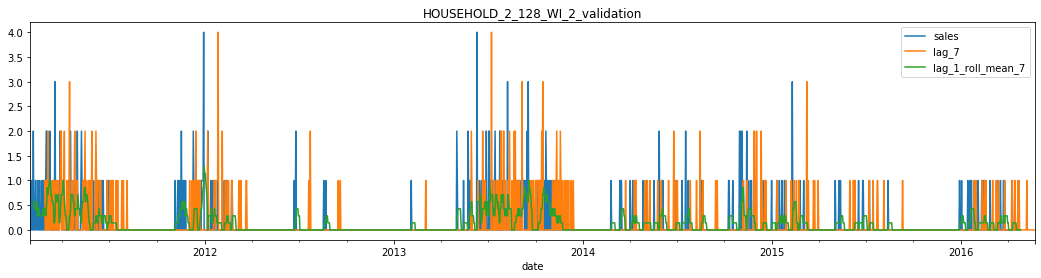

In [10]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_28'].plot(label='lag_7')
id_sales['lag_1_roll_mean_7'].plot(label='lag_1_roll_mean_7')
plt.title(id_name)
plt.legend()
plt.show()

In [15]:
train_cols = strain.columns[~strain.columns.isin(DROP_COLS)]
store_ids = list(strain['store_id'].unique())
print('stores:', store_ids)

stores: ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']


In [28]:
start_time = time.time()
for store_id in tqdm(store_ids):
    print('-' * 10, 'store training:', store_id, '-' * 10)
    X_train = strain[
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ][train_cols]
    y_train = strain[
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ]['sales']
    X_val = strain[
        (strain['d'] > (END_D - PRED_FWD)) & 
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ][train_cols]
    y_val = strain[
        (strain['d'] > (END_D - PRED_FWD)) & 
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ]['sales']
    print('train shapes:', X_train.shape, len(y_train))
    print('val shapes:', X_val.shape, len(y_val))
    train_pool = Pool(X_train, y_train, cat_features=CAT_COLS)
    val_pool = Pool(X_val, y_val, cat_features=CAT_COLS)
    del X_train, y_train, X_val, y_val
    gc.collect()
    model = CatBoostRegressor(
        iterations=1400,
        task_type='GPU', # 'CPU'
        verbose=0,
        loss_function='RMSE',
        #loss_function='Tweedie:variance_power=1.1', grow_policy='Depthwise',
        boosting_type='Plain',
        #depth=8,
        #gpu_cat_features_storage='CpuPinnedMemory',
        #max_ctr_complexity=2,
        #l2_leaf_reg=3
    )
    model.fit(
        train_pool,
        eval_set=val_pool,
        plot=True   
    )
    model_file = '{}/model_{}_store_{}.cbm'.format(MODELS_DIR, MODEL_VER, store_id)
    model.save_model(model_file)
    print('save to file:', model_file)
elapsed_time = time.time() - start_time
print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))

---------- store training: CA_1 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_CA_1.cbm
---------- store training: CA_2 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_CA_2.cbm
---------- store training: CA_3 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_CA_3.cbm
---------- store training: CA_4 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_CA_4.cbm
---------- store training: TX_1 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_TX_1.cbm
---------- store training: TX_2 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_TX_2.cbm
---------- store training: TX_3 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_TX_3.cbm
---------- store training: WI_1 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_WI_1.cbm
---------- store training: WI_2 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_WI_2.cbm
---------- store training: WI_3 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

save to file: C:/data/m5/models/model_v0_store_WI_3.cbm

time elapsed: 124 min 20 sec


In [29]:
store_id = 'CA_1'
model_file = '{}/model_{}_store_{}.cbm'.format(MODELS_DIR, MODEL_VER, store_id)
model = CatBoostRegressor().load_model(model_file)
#model

In [30]:
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, model.get_feature_importance())],
    key=lambda x: x[1],
    reverse=True
)

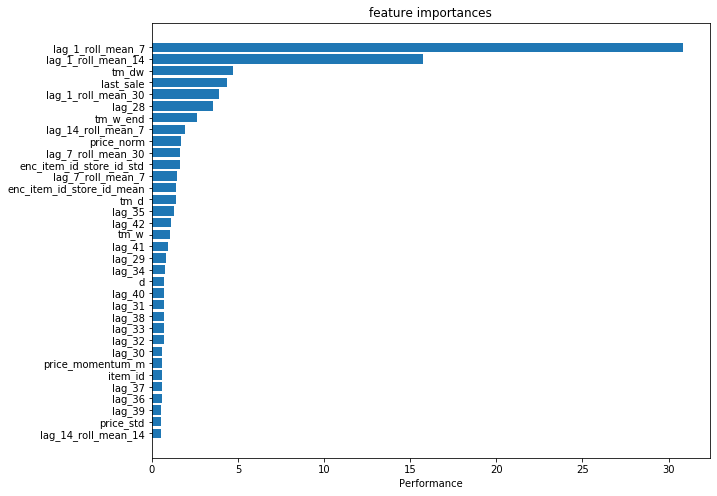

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
labels, values = [x[0] for x in feat_importances if x[1] > .5], [x[1] for x in feat_importances if x[1] > .5]
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [32]:
%%time
spred = strain[
    (strain['d'] > (END_D - PRED_FWD)) &
    (strain['d'] <= END_D) &
    (strain['store_id'] == store_id)
].copy()
preds = model.predict(spred[train_cols])
print(len(preds))
spred.loc[:, 'sales'] = preds

85372
Wall time: 5.98 s


id to draw: FOODS_1_155_CA_1_validation


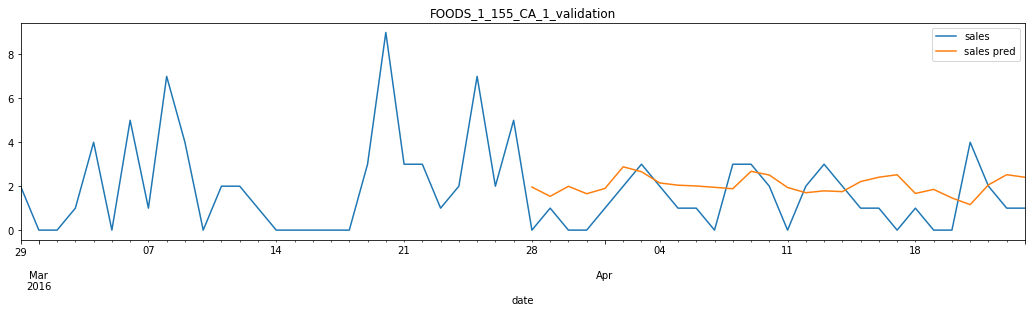

In [33]:
id_name = np.random.choice(strain[strain['store_id'] == store_id]['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - 2 * PRED_FWD)) &
    (strain['d'] <= END_D) &
    (strain['store_id'] == store_id)
].set_index('date')
id_sales_pred = spred.loc[spred['id'] == id_name].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales pred')
plt.title(id_name)
plt.legend()
plt.show()

In [34]:
for pred_d in tqdm(range(1, PRED_FWD + 1)):
    print('=' * 10, 'forecast day forward:', pred_d, '=' * 10) 
    strain = make_features_last_sales(strain)
    spred = strain[strain['d'] > (END_D - 100)].copy()
    spred = make_features_win(spred)
    for store_id in store_ids:
        model_file = '{}/model_{}_store_{}.cbm'.format(MODELS_DIR, MODEL_VER, store_id)
        model = CatBoostRegressor().load_model(model_file)
        strain.loc[
            (strain['d'] == (END_D + pred_d)) & (strain['store_id'] == store_id), 
            'sales'
        ] = model.predict(
            spred.loc[
                (spred['d'] == (END_D + pred_d)) & (spred['store_id'] == store_id), 
                train_cols
            ]
        )
        print('store predicted:', store_id, '| model:', model_file)
    all_sales = strain[strain['d'] == (END_D + pred_d)]['sales'].values
    print('day forward:', END_D + pred_d, 'all sales:', np.sum(all_sales))

========== forecast day forward: 1 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 103)
last non zero sales done
out dataframe: (59181090, 103)
time elapsed: 1 min 29 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 103)
window roll mean sales done
out dataframe: (3902720, 103)
time elapsed: 3 min 55 sec
store predicted: CA_1 | model: C:/data/m5/models/model_v0_store_CA_1.cbm
store predicted: CA_2 | model: C:/data/m5/models/model_v0_store_CA_2.cbm
store predicted: CA_3 | model: C:/data/m5/models/model_v0_store_CA_3.cbm
store predicted: CA_4 | model: C:/data/m5/models/model_v0_store_CA_4.cbm
store predicted: TX_1 | model: C:/data/m5/models/model_v0_store_TX_1.cbm
store predicted: TX_2 | model: C:/data/m5/models/model_v0_store_TX_2.cbm
store predicted: TX_3 | model: C:/data/m5/models/model_v0_store_TX_3.cbm
store predicted: WI_1 | model: C:/data/m5/models/model_v0_store_WI_1.cbm
store predicted: WI_2 | model: C:/data/m5/models/model_v0_stor

store predicted: CA_1 | model: C:/data/m5/models/model_v0_store_CA_1.cbm
store predicted: CA_2 | model: C:/data/m5/models/model_v0_store_CA_2.cbm
store predicted: CA_3 | model: C:/data/m5/models/model_v0_store_CA_3.cbm
store predicted: CA_4 | model: C:/data/m5/models/model_v0_store_CA_4.cbm
store predicted: TX_1 | model: C:/data/m5/models/model_v0_store_TX_1.cbm
store predicted: TX_2 | model: C:/data/m5/models/model_v0_store_TX_2.cbm
store predicted: TX_3 | model: C:/data/m5/models/model_v0_store_TX_3.cbm
store predicted: WI_1 | model: C:/data/m5/models/model_v0_store_WI_1.cbm
store predicted: WI_2 | model: C:/data/m5/models/model_v0_store_WI_2.cbm
store predicted: WI_3 | model: C:/data/m5/models/model_v0_store_WI_3.cbm
day forward: 1921 all sales: 47161.4386550347
========== forecast day forward: 9 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 103)
last non zero sales done
out dataframe: (59181090, 103)
time elapsed: 1 min 28 sec
---------- WIN ROLL FEAT

store predicted: TX_1 | model: C:/data/m5/models/model_v0_store_TX_1.cbm
store predicted: TX_2 | model: C:/data/m5/models/model_v0_store_TX_2.cbm
store predicted: TX_3 | model: C:/data/m5/models/model_v0_store_TX_3.cbm
store predicted: WI_1 | model: C:/data/m5/models/model_v0_store_WI_1.cbm
store predicted: WI_2 | model: C:/data/m5/models/model_v0_store_WI_2.cbm
store predicted: WI_3 | model: C:/data/m5/models/model_v0_store_WI_3.cbm
day forward: 1928 all sales: 46342.9778488153
========== forecast day forward: 16 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 103)
last non zero sales done
out dataframe: (59181090, 103)
time elapsed: 1 min 28 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 103)
window roll mean sales done
out dataframe: (3902720, 103)
time elapsed: 3 min 55 sec
store predicted: CA_1 | model: C:/data/m5/models/model_v0_store_CA_1.cbm
store predicted: CA_2 | model: C:/data/m5/models/model_v0_store_CA_2.cbm
store predicted

store predicted: WI_2 | model: C:/data/m5/models/model_v0_store_WI_2.cbm
store predicted: WI_3 | model: C:/data/m5/models/model_v0_store_WI_3.cbm
day forward: 1935 all sales: 42588.80719243034
========== forecast day forward: 23 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 103)
last non zero sales done
out dataframe: (59181090, 103)
time elapsed: 1 min 28 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 103)
window roll mean sales done
out dataframe: (3902720, 103)
time elapsed: 3 min 55 sec
store predicted: CA_1 | model: C:/data/m5/models/model_v0_store_CA_1.cbm
store predicted: CA_2 | model: C:/data/m5/models/model_v0_store_CA_2.cbm
store predicted: CA_3 | model: C:/data/m5/models/model_v0_store_CA_3.cbm
store predicted: CA_4 | model: C:/data/m5/models/model_v0_store_CA_4.cbm
store predicted: TX_1 | model: C:/data/m5/models/model_v0_store_TX_1.cbm
store predicted: TX_2 | model: C:/data/m5/models/model_v0_store_TX_2.cbm
store predicte

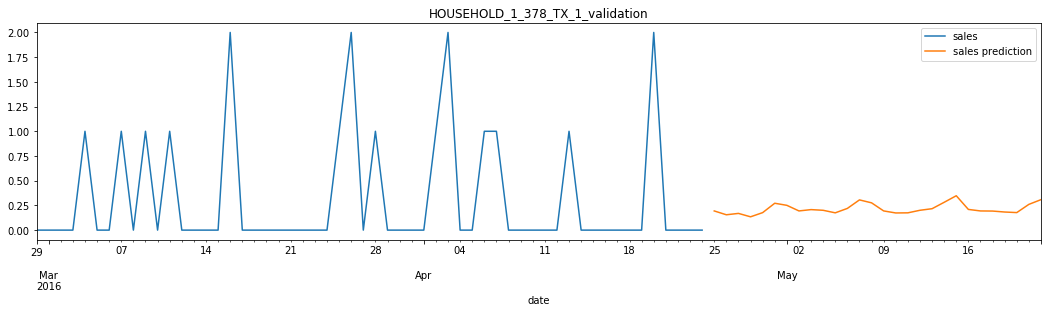

In [35]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - 2 * PRED_FWD)) &
    (strain['d'] <= END_D)
].set_index('date')
id_sales_pred = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > END_D)
].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [36]:
spred_subm = strain.loc[strain['d'] > END_D, ['id', 'd', 'sales']].copy()
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(x - END_D))
spred_subm.loc[spred_subm['sales'] < 0, 'sales'] = 0

In [37]:
f_cols = ['F{}'.format(x) for x in range(1, PRED_FWD + 1)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d                           id        F1        F2        F3        F4  \
0  FOODS_1_001_CA_1_validation  0.898059  0.779493  0.766655  0.781430   
1  FOODS_1_001_CA_2_validation  1.171725  1.167139  1.151463  1.255933   
2  FOODS_1_001_CA_3_validation  0.824226  0.916016  0.900935  0.795634   
3  FOODS_1_001_CA_4_validation  0.391989  0.338679  0.351685  0.329368   
4  FOODS_1_001_TX_1_validation  0.130986  0.413637  0.371578  0.356116   

d        F5        F6        F7        F8        F9       F10       F11  \
0  1.031884  1.290646  1.147630  1.043402  0.992156  0.891928  0.774642   
1  1.499925  2.005101  1.832217  1.222977  1.229541  1.120113  1.125632   
2  1.139400  1.846897  2.297967  1.281286  1.250254  1.129913  0.992778   
3  0.406635  0.417890  0.379333  0.397047  0.325609  0.338337  0.297972   
4  0.377515  0.489329  0.538686  0.488369  0.547352  0.481619  0.488928   

d       F12       F13       F14       F15       F16       F17       F18  \
0  1.077376  1.215903  0.917954  0.969135  0.875765  0.792329  0.794888   
1  1.433071  1.892300  1.551753  1.260952  1.268053  1.206461  1.196772   
2  1.273326  1.814867  1.525633  1.286956  1.212069  1.381300  1.310955   
3  0.359927  0.426247  0.322927  0.384813  0.333566  0.434015  0.427726   
4  0.544187  0.672540  0.620074  0.584415  0.407306  0.455861  0.475076   

d       F19       F20       F21       F22       F23       F24       F25  \
0  1.016133  1.192685  1.133276  1.004194  0.827392  0.773970  0.752184   
1  1.512726  1.996536  2.041549  1.086354  1.288327  1.182184  1.295929   
2  1.380390  1.850865  2.185388  1.474656  1.439863  1.392984  1.314887   
3  0.506558  0.575515  0.550412  0.379652  0.332506  0.384446  0.371422   
4  0.466247  0.593773  0.698363  0.515251  0.493220  0.482643  0.469976   

d       F26       F27       F28  
0  0.951276  1.144606  1.135977  
1  1.480101  1.968261  2.061188  
2  1.389618  2.170590  2.207286  
3  0.402319  0.432758  0.412829  
4  0.462895  0.603345  0.693337

In [38]:
spred_subm_eval = spred_subm.copy()
spred_subm_eval['id'] = spred_subm_eval['id'].str.replace('validation', 'evaluation')
spred_subm = pd.concat([spred_subm, spred_subm_eval], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('submission.csv', index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)
